In [ ]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import shutil
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger

import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets_torch_geometric.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
entity = "haraghi"
project = "DGCNN"

In [ ]:
resutls = torch.load("sparsity_sensitivity_results_nasl5.pt")
tested_num_events = []
trained_num_events = []
for dataset_name, dataset_results in resutls.items():
    print(dataset_name)
    for run_id, run_results in dataset_results.items():
        if run_results['trained_num_events'] is not None:
            trained_num_events.append(f"{run_id},{run_results['trained_num_events']},({run_results['summary_test_acc']:.4f})")
        tested_num_events.extend(list(run_results["tested_num_events"].keys()))


    tested_num_events = sorted(list(set(tested_num_events)))
    trained_num_events = sorted(trained_num_events, key=lambda x: int(x.split(",")[1]))

    mat = []
    mat_dict = {}
    for row in trained_num_events:
        row_results = []
        run_id = row.split(",")[0]
        mat_dict[run_id] = {}
        for col in tested_num_events:
            if col in resutls[dataset_name][run_id]['tested_num_events']:
                row_results.append(     [t_r[0]['test/acc'] for t_r in dataset_results[run_id]['tested_num_events'][col]])
                mat_dict[run_id][col] = [t_r[0]['test/acc'] for t_r in dataset_results[run_id]['tested_num_events'][col]]
                test_number = len(dataset_results[run_id]['tested_num_events'][col])
            else:
                row_results.append(None)
                mat_dict[run_id][col] = None
        mat.append(row_results)
       

In [ ]:
for i,r in enumerate(mat):
    for j,c in enumerate(r):
        if c is None:
            mat[i][j] = [np.nan]*test_number

mat = np.array(mat)


(array([3., 1., 3., 3., 3., 2., 2., 0., 0., 3.]),
 array([0.69230771, 0.71025643, 0.72820514, 0.74615386, 0.76410258,
        0.7820513 , 0.80000001, 0.81794873, 0.83589745, 0.85384616,
        0.87179488]),
 <BarContainer object of 10 artists>)

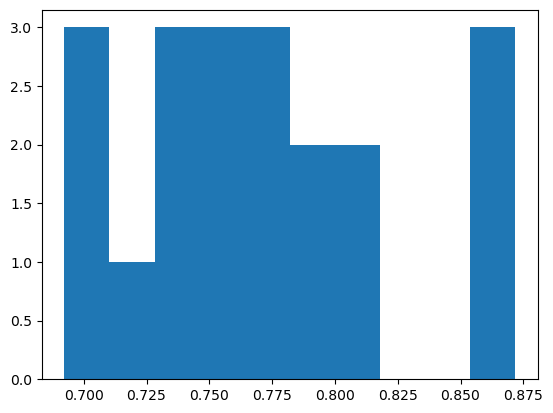

In [10]:
plt.hist(mat_dict['sx3f1cu2'][1024])


In [ ]:
trained_num_events

In [ ]:
tested_num_events_to_exclude = [10,12,14]
trained_models_to_exclude = [   'icey2rjl',
                                '7zx0vpka',
                                '3ui1yw0g',
                                'w01ii3fi',
                                'dv55wg8g',
                                'kx7h5a2s',
                                '8qq7350v',
                                '6lbum0nu',
                                'vwoabjqc',
                                'lth39qma',
                                'sdt62qp2',
                                '17id13t6']


# Define the rows and columns to exclude
rows_to_exclude = [i for i,t in enumerate(trained_num_events) if t.split(",")[0] in trained_models_to_exclude]
cols_to_exclude = [i for i,t in enumerate(tested_num_events) if t in tested_num_events_to_exclude]

trained_num_events = [t for i,t in enumerate(trained_num_events) if i not in rows_to_exclude]
tested_num_events = [t for i,t in enumerate(tested_num_events) if i not in cols_to_exclude]


print(mat.shape)
# Exclude the rows and columns from mat
mat_filtered = np.delete(mat, rows_to_exclude, axis=0)
print(mat_filtered.shape)
mat_filtered = np.delete(mat_filtered, cols_to_exclude, axis=1)
print(mat_filtered.shape)
mat_mean = np.nanmean(mat_filtered, axis=2)
mat_std = np.nanstd(mat_filtered, axis=2)


In [ ]:

figure = plt.figure(figsize=(6, 12))
ax = plt.gca()
im = ax.imshow(mat_mean)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tested_num_events)), labels=tested_num_events)
ax.set_yticks(np.arange(len(trained_num_events)), labels=trained_num_events)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trained_num_events)):
    for j in range(len(tested_num_events)):
        text = ax.text(j, i, f'{100*mat_mean[i, j]:.2f}\n±{100*mat_std[i, j]:.2f}',
                       ha="center", va="center", color="w")

plt.colorbar(im, fraction=0.04, pad=0.04)
plt.xlabel("Tested number of events")
plt.ylabel("Trained number of events")
plt.show()